# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify fabrication uncertainties in MEMS accelerometers. We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [22]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 


#### Decide sample to use for experimental data

In [23]:
sample = 110 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

#### Set Bayesian Identification Parameters

In [24]:
# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
CONFIGURATION_II = './config_II.json'

# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 1000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2

noise


0.005

#### Load Surrogate Models

In [25]:
# Data preprocessing for both configurations
data_processor_I = preprocessing(CONFIGURATION_I)
data_processor_II = preprocessing(CONFIGURATION_II)

# Import the function coarse_model
sys.path.append('../../tests/Xaccelerometer_geometric/models')
from coarse_model import *

# Extract test data for visualization or further processing
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test




In [26]:
num_samples = 640
num_parameters = 3
num_coarse_values = 75
# Define the neural network model
model_lowfidelity_NN = Sequential([
        Dense(150,input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])
# Load the model
model_lowfidelity_NN = load_model('./models/model_LF_NN_oo3.keras')
model_lf = create_model_LF_NN_oo3_opt()

/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Define a custom Uniform random variable class

In [27]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):   
        if  self.pdf(x)==0:
            return -np.inf
        else:
            return np.log(self.pdf(x))
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [28]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=np.sqrt(noise),size=y_true.shape[0]) 

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(data_processor_I.time)) 
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood*10) 

#### Perform least square optimization for each starting point

In [29]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")


Real Params:  [ 0.317228  0.314022 30.854021]
Optimized Params 1: [ 0.31593046  0.3178216  30.36985105]
Optimized Params 2: [ 0.31593046  0.31782161 30.36985027]
Optimized Params 3: [ 0.31593046  0.3178216  30.36985098]
Optimized Params 4: [ 0.31593046  0.3178216  30.36985097]
Optimized Params 5: [ 0.31593046  0.3178216  30.36985119]


#### Do Metropolis Hastings Sampling

In [30]:
# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_lf )
# random walk Metropolis
my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= 0.3)

# get the maximum a posteriori point / 
#MAP = tda.get_MAP(my_posterior)


In [31]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=initial_guess)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(MCMC_SETTINGS['Nb'], None, MCMC_SETTINGS['Nt']), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    ESS_values.append([ess['Overetch'].values, ess['Offset'].values, ess['Thickness'].values])
    
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

print('Mean ESS:' , np.mean(ESS_values, axis = 0))
print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )


# Save the numpy array to a file
np.save(OUTPUT_FILENAME, np.array([samples_mh[0].posterior['Overetch'].values[0], samples_mh[0].posterior['Offset'].values[0], samples_mh[0].posterior['Thickness'].values[0] ]) )  

Sampling chain 1/1


Running chain, α = 0.26: 100%|██████████| 6000/6000 [00:09<00:00, 632.41it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 278.7
    Offset     float64 8B 311.3
    Thickness  float64 8B 298.3 



Sampling chain 1/1


Running chain, α = 0.24: 100%|██████████| 6000/6000 [00:09<00:00, 652.89it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 342.9
    Offset     float64 8B 308.2
    Thickness  float64 8B 305.7 



Sampling chain 1/1


Running chain, α = 0.28: 100%|██████████| 6000/6000 [00:09<00:00, 608.30it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 339.6
    Offset     float64 8B 415.4
    Thickness  float64 8B 417.4 



Sampling chain 1/1


Running chain, α = 0.28: 100%|██████████| 6000/6000 [00:08<00:00, 668.79it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 381.8
    Offset     float64 8B 288.5
    Thickness  float64 8B 294.4 



Sampling chain 1/1


Running chain, α = 0.30: 100%|██████████| 6000/6000 [00:09<00:00, 666.12it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 477.4
    Offset     float64 8B 334.2
    Thickness  float64 8B 438.0 




Rhat:  <xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    Overetch   float64 8B 1.0
    Offset     float64 8B 1.001
    Thickness  float64 8B 1.001
Mean ESS: [364.09721596 331.52289259 350.76059878]
Time/ESS MDA [0.02578005 0.02831311 0.02676026]


/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [32]:
np.mean(ESS_values, axis = 0)

array([364.09721596, 331.52289259, 350.76059878])

Let's look at the trace plot of one chain

# Diagnostics 

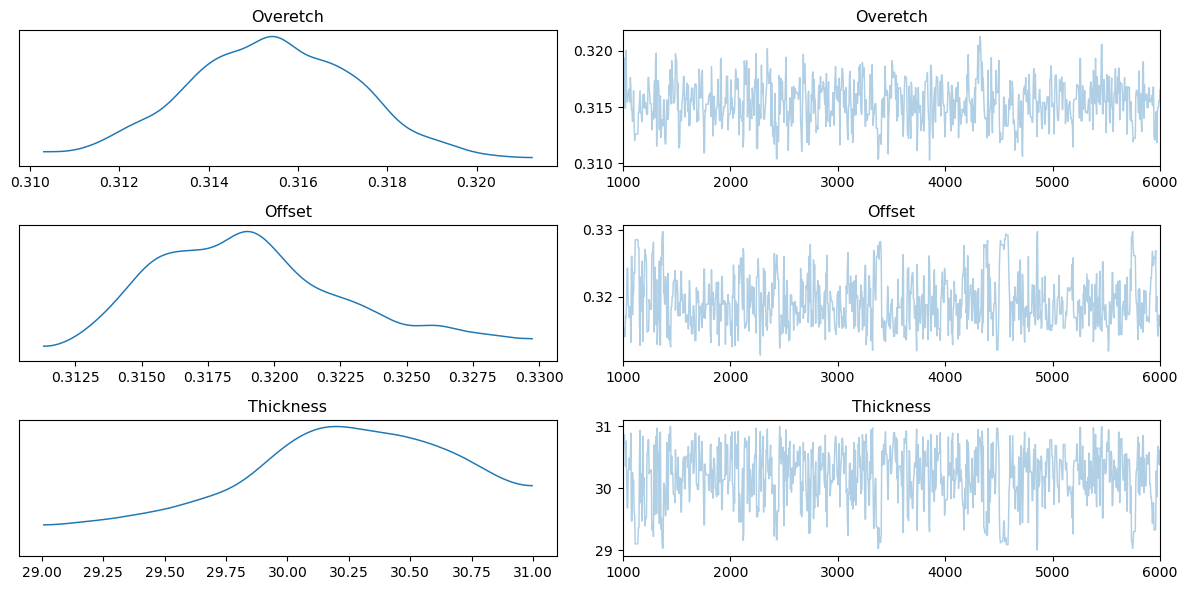

In [33]:
# Plot trace of the first set of samples
#idata = samples_mh[2].sel(draw=slice(MCMC_SETTINGS['Nb'], None,MCMC_SETTINGS['Nt']))
idata = samples_mh[1]
az.plot_trace(idata)
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

In [34]:
def plot_results(time, y_true, y_obs, model, samplesMH, REAL_COLOR='red', LINE_WIDTH=1.5):
    plt.figure()
    plt.plot(1e3*time, y_true, c=REAL_COLOR, label='Real', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, model(np.mean(samplesMH, axis=1)), 'green', label='Pred', linewidth=LINE_WIDTH)
    plt.plot(1e3*time, y_obs, '.-b', label='Noisy Signal', linewidth=LINE_WIDTH)
    #plt.plot(1e3*time, model(x_true), 'black', label = 'True parameters')
    plt.xlabel('Time [ms]')
    plt.ylabel(r'$\Delta C$ [fF]')
    plt.title(f'Overetch = {np.mean(samplesMH, axis=1)[0]:.4f}μm; Offset = {np.mean(samplesMH, axis=1)[1]:.4f}μm; Thickness = {np.mean(samplesMH, axis=1)[2]:.4f}μm', fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

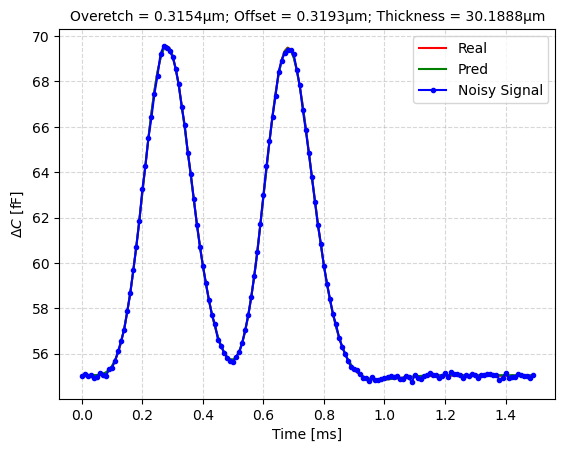

In [35]:
# Plotting and data collection
data = az.convert_to_dataset
data = np.array([idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ]) 
plot_results(data_processor_I.time, y_true, y_observed, model_lf, data)

Finally, let's look at the parameters distribution

In [36]:
def plot_parameter_distribution(parameter_samples, x_true, parameter_name):
    plt.figure()
    kernel_density = gaussian_kde(parameter_samples)
    x_range = np.linspace(np.min(parameter_samples), np.max(parameter_samples), 1000)
    plt.plot(x_range, kernel_density(x_range), label='Density', linewidth=2)
    plt.axvline(x_true, color='red', label='Exact', linestyle='-', linewidth=2)
    mean, mode = np.mean(parameter_samples), x_range[np.argmax(kernel_density(x_range))]
    plt.axvline(mean, color='green', label='Mean', linestyle='--', linewidth=2)
    plt.axvline(mode, color='blue', label='Mode', linestyle='--', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples, [2.5, 97.5])
    plt.fill_between(x_range, 0, kernel_density(x_range), where=((x_range >= lower_bound) & (x_range <= upper_bound)), alpha=0.3, color='gray', label='95% C.I.')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

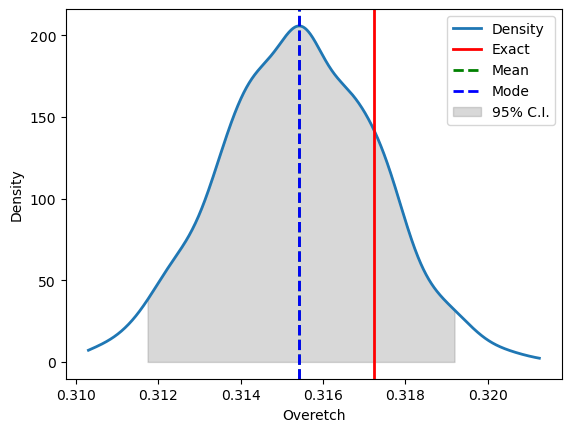

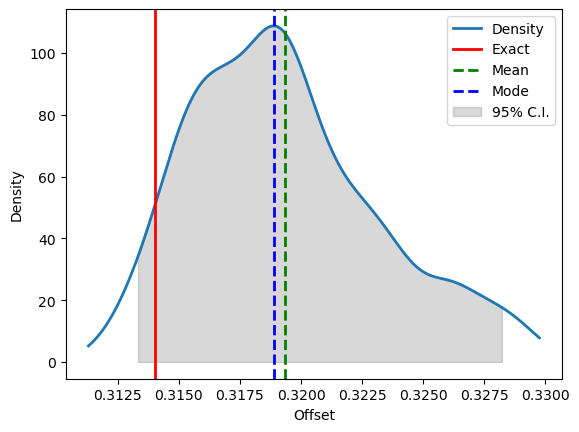

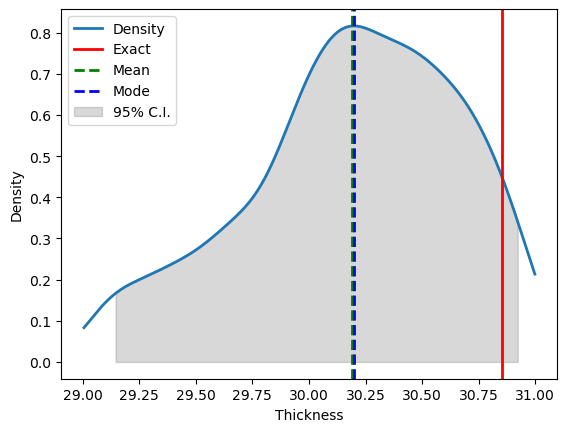

In [37]:
for j in range(3):
    plot_parameter_distribution(data[j,:], x_true[j], ['Overetch', 'Offset', 'Thickness'][j])

# Post Processing Plots

This section generates the plots in the paper.

In [38]:
from plotsPaper import *
samples = np.load(OUTPUT_FILENAME+'.npy')

##### Histograms of the geometric parameters

In [48]:
def plot_histograms(samples, true_params):

    num_params = samples.shape[0]
    param_names = ['Overetch', 'Offset', 'Thickness']

    sigma = [0.4,1,2]
    avgi = [0.3,0.0,30.0]
    sim_avg = ['Oavg','Uavg','Tavg']
    
    for i in range(num_params):
        plt.figure()
        n, bins, _ = plt.hist(samples[i, :], bins=50, density=True, color='skyblue', edgecolor='black')
        mean_value = np.mean(samples[i, :])
        ci_lower, ci_upper = np.percentile(samples[i, :], [5, 95])

        plt.axvline(true_params[i], color='darkred', linestyle='dashed', linewidth=3, label='True')
        plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=3, label='Mean')
        plt.fill_betweenx([0, max(n)], ci_lower, ci_upper, color='gray', alpha=0.35, label='95% CI')

        ratio_lower = (ci_lower-avgi[i]) / sigma[i]
        ratio_upper = (ci_upper-avgi[i]) / sigma[i]
        sym_lower = ""
        sym_upper = ""
        if ratio_lower>0:
            sym_lower = "+"
        if ratio_upper>0:
            sym_upper = "+"
        s = ['O','U','T']
        #plt.xticks([ci_lower,ci_upper],[sim_avg[i]+sym_lower+f'{ratio_lower:.4f} $\sigma_'+s[i]+'$',sim_avg[i]+sym_upper+f'{ratio_upper:.4f} $\sigma_'+s[i]+'$'])
        plt.xticks([ci_lower,ci_upper],[round(ci_lower,3), round(ci_upper,3)])
        plt.xlabel(param_names[i], fontsize=14)
        plt.ylabel('Density', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

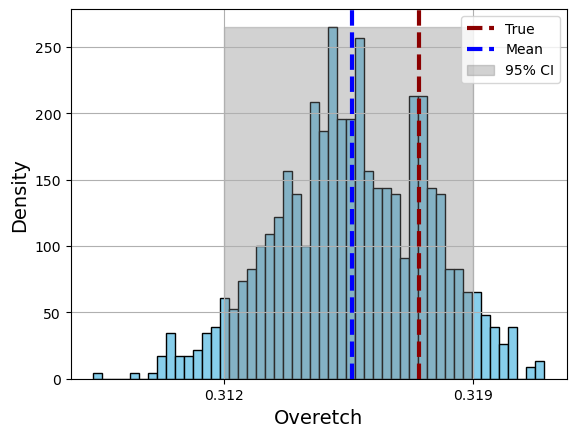

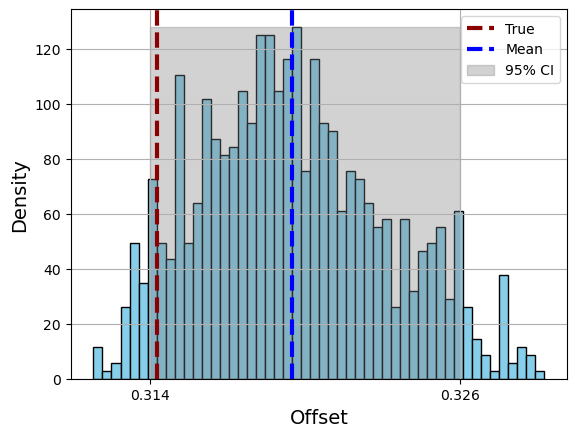

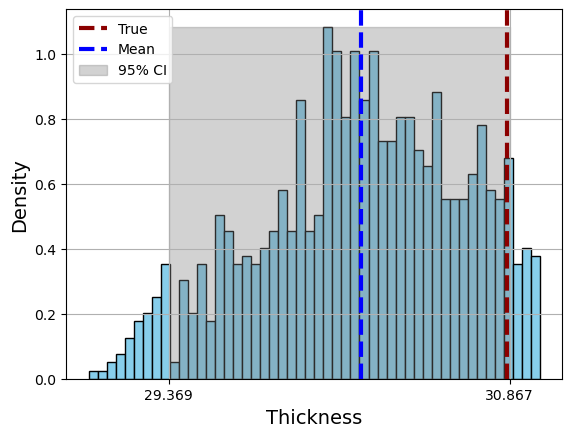

In [49]:
plot_histograms(samples, x_true)

ciao


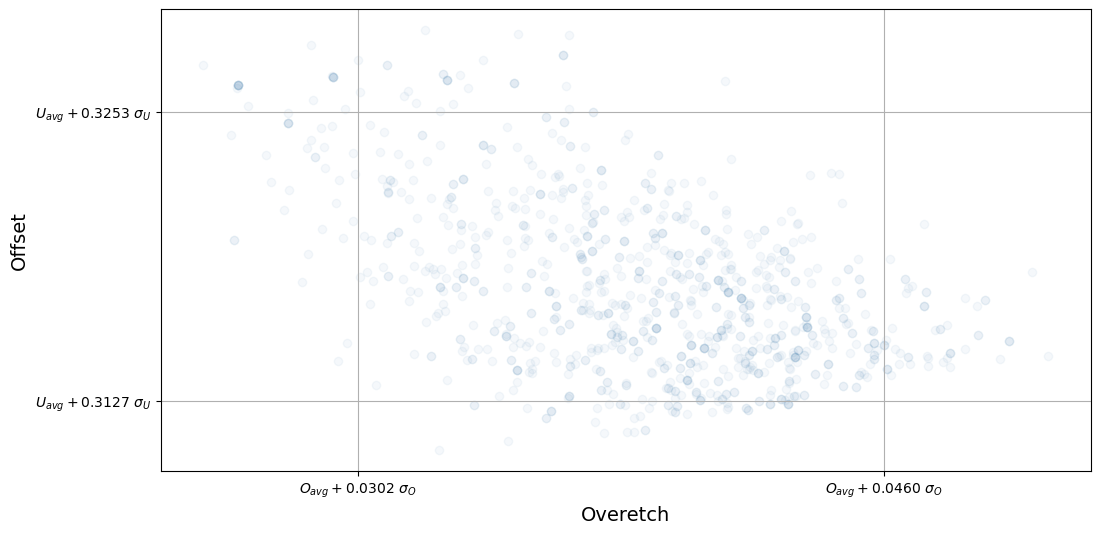

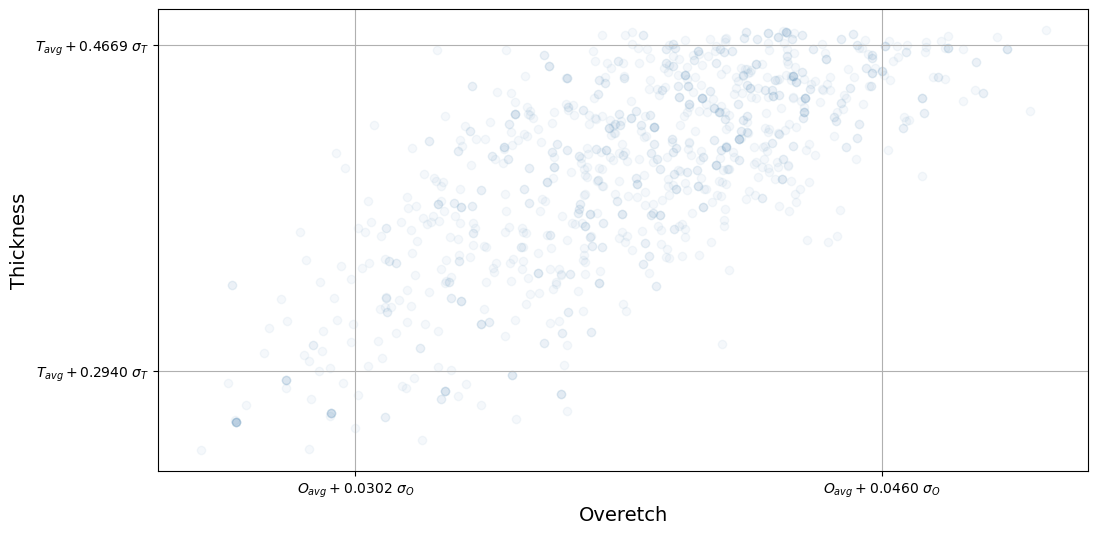

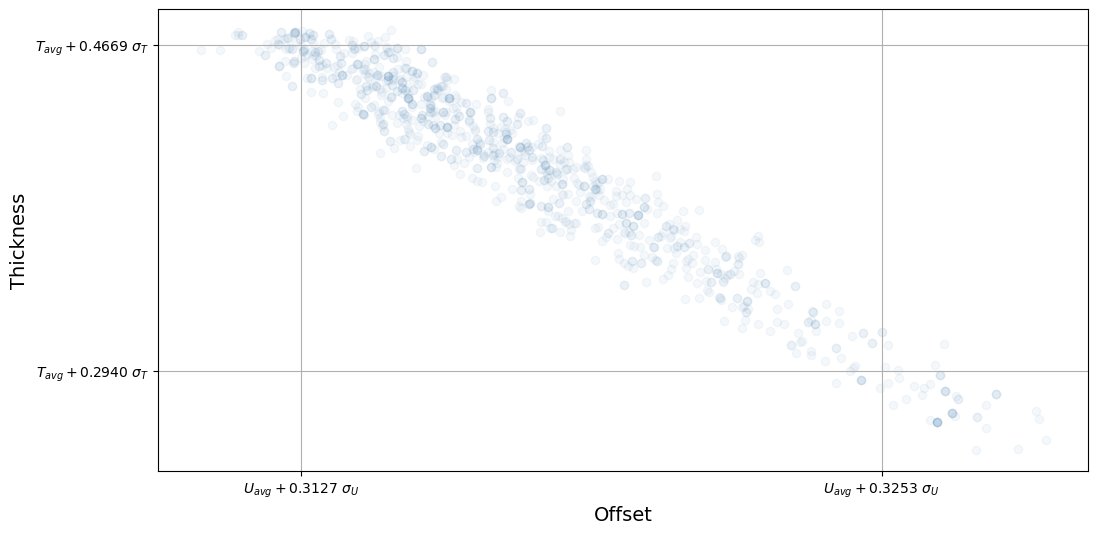

In [79]:
plot_scatter(samples)

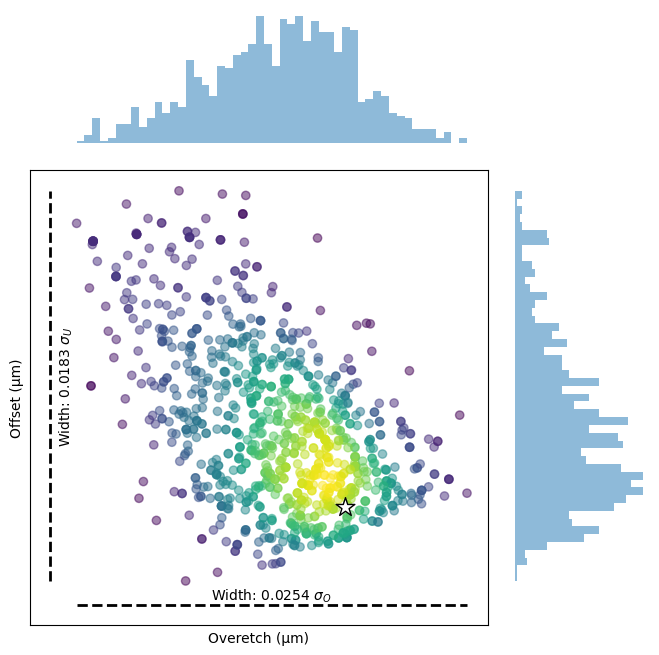

In [80]:
plot_density_scatter(samples, x_true, sigma_values=(0.2, 0.5))  # Adjust sigma values as needed

# Check

Now i want to see what is the mse of the recontruction through the true paramters and the mean that we have found 

In [81]:
print('The true parameters are:', x_true)
x_estimated = np.mean(data, axis = 1)
print('The estimated params are:', x_estimated)

print('\n\nMSE with true parameters:', ((y_true - model_lf(x_true))**2).sum()/150 ) 
print('MSE with estim parameters:', ((y_true - model_lf(x_estimated))**2).sum()/150 ) 

print('\n\nMSE with true parameters, and data obs:', ((y_observed - model_lf(x_true))**2).sum()/150)
print('MSE with estim parameters and data obs:', ((y_observed - model_lf(x_estimated))**2).sum()/150 ) 


The true parameters are: [ 0.317228  0.314022 30.854021]
The estimated params are: [ 0.31548801  0.3176488  30.36370861]


MSE with true parameters: 0.00021002449773166963
MSE with estim parameters: 0.0003099816967005021


MSE with true parameters, and data obs: 0.00022556478028172672
MSE with estim parameters and data obs: 0.00032903155277535015


# See performance for 10 samples 

In [20]:
n = 10
random_samples = [ 125,  60,  53,  89,   9,  61, 156,  99,  92, 115] #np.random.choice(np.arange(160), size=n, replace=False)
print('The extracted samples are: ', random_samples)

samples_box = []

for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 
    # set the likelihood
    y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood*10) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior = tda.Posterior(x_distribution, y_distribution, model_lf )
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.3) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=init_guess)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(MCMC_SETTINGS['Nb'], None, MCMC_SETTINGS['Nt']), groups="posterior")
    # Append the samples to the list
    samples_box.append( [idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ])
    
print(samples_box[0][0])


The extracted samples are:  [125, 60, 53, 89, 9, 61, 156, 99, 92, 115]
[ 0.164034  0.281502 30.758818]
Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:05<00:00, 1115.54it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.464787 -0.34692  29.295773]
Sampling chain 1/1


Running chain, α = 0.26: 100%|██████████| 6000/6000 [00:04<00:00, 1304.85it/s]


[ 0.391841  0.24583  29.104798]
Sampling chain 1/1


Running chain, α = 0.12: 100%|██████████| 6000/6000 [00:04<00:00, 1278.04it/s]


[ 0.381797  0.116394 29.238688]
Sampling chain 1/1


Running chain, α = 0.30: 100%|██████████| 6000/6000 [00:04<00:00, 1296.16it/s]


[ 0.417828 -0.33801  29.213157]
Sampling chain 1/1


Running chain, α = 0.30: 100%|██████████| 6000/6000 [00:04<00:00, 1271.65it/s]


[ 0.18104   0.097916 29.566415]
Sampling chain 1/1


Running chain, α = 0.36: 100%|██████████| 6000/6000 [00:04<00:00, 1255.36it/s]


[ 0.339759  0.329625 29.711193]
Sampling chain 1/1


Running chain, α = 0.17: 100%|██████████| 6000/6000 [00:04<00:00, 1306.60it/s]


[ 0.478572 -0.036052 30.60058 ]
Sampling chain 1/1


Running chain, α = 0.26: 100%|██████████| 6000/6000 [00:04<00:00, 1295.89it/s]


[ 0.270542  0.352424 30.628894]
Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 6000/6000 [00:04<00:00, 1322.13it/s]


[ 0.493409  0.207659 30.163214]
Sampling chain 1/1


Running chain, α = 0.31: 100%|██████████| 6000/6000 [00:04<00:00, 1359.95it/s]


[0.16429864 0.16429864 0.16429864 ... 0.16100973 0.16068072 0.16068072]


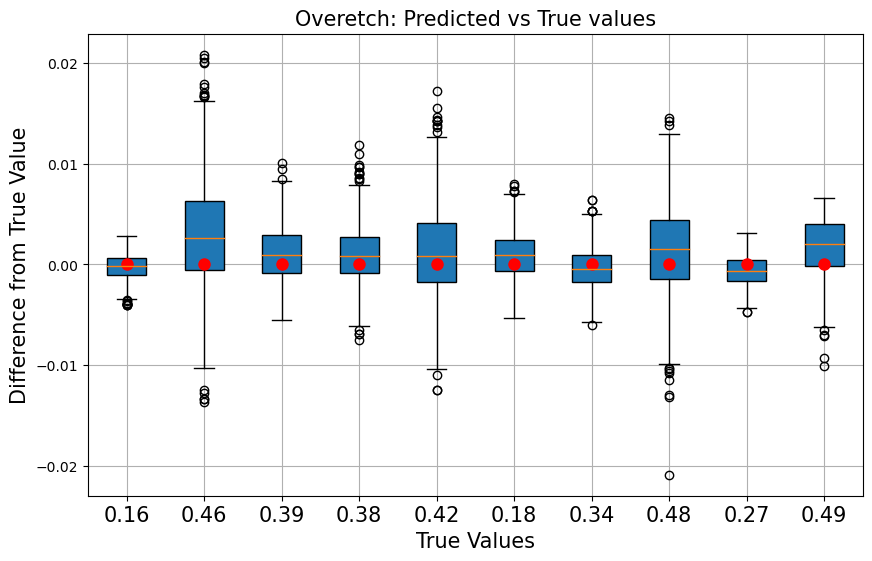

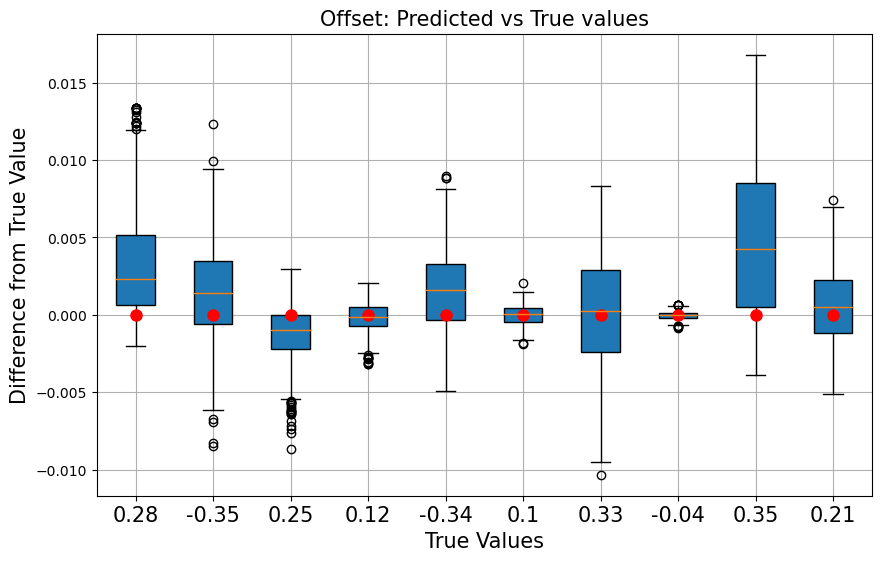

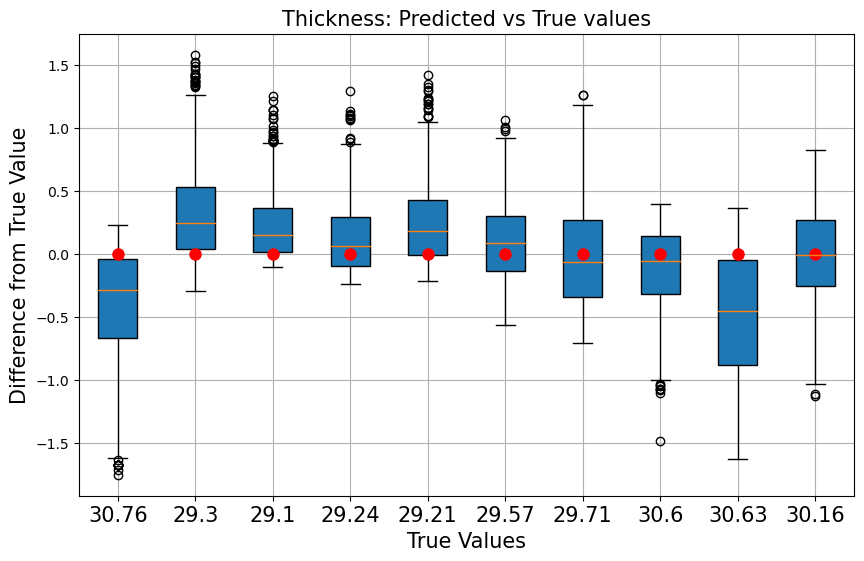

In [21]:
names = ['Overetch', 'Offset', 'Thickness']
for i in range(3):
    #Create a dataset containing all the same parameter samples 
    plot_data = []
    true_val = []
    for j in range(n):
        true_val.append(X_values[random_samples[j]][i])
        plot_data.append(samples_box[j][i]- true_val[j])

    # Plot box plots
    plt.figure(figsize=(10, 6))
    plt.boxplot(plot_data, patch_artist=True)

    # Plot the mean values
    for idx, mean in enumerate(true_val):
        plt.plot(idx + 1, mean*0, 'ro', label='Mean', markersize=8)

    # Add labels and title
    plt.xlabel('True Values',size= 15)
    plt.ylabel('Difference from True Value',size= 15)
    plt.title(names[i] + ': Predicted vs True values',size= 15)
    plt.xticks(np.arange(1, n + 1), np.round(true_val,2), size= 15)
    plt.grid(True)
    plt.show()